<a href="https://colab.research.google.com/github/Kiarashmo/Apnea-Detection-with-AnisotropicResNet/blob/main/Apnea_Detection_with_AnisotropicResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 0. Configuration, Utilities, and Imports

In [ ]:
# Configuration Parameters
class Config:
    # File paths and model configuration
    Raw_Dir = '/content/drive/MyDrive/CBRC-Apnea/data/raw_data/'  # Path to raw audio data directory
    Labels_Filepath = '/content/drive/MyDrive/CBRC-Apnea/data/filtered_labels_above10.csv'  # Path to labels file
    Sampling_Rate = 8000  # Sampling rate for audio files
    Context_Window = 20  # Context window size in seconds
    Prediction_Window = 10  # Prediction window size in seconds

# Install necessary Python packages for the project
!pip install torchmetrics

# Import necessary libraries and modules
import os
from os.path import splitext, join, basename

import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import datetime
import copy

import librosa
from librosa.core import power_to_db
from librosa.feature import melspectrogram, rms, mfcc

from scipy import signal
from skimage.util import view_as_windows
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import MultilabelF1Score, BinaryF1Score

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_audio(file_path, sr):
    """
    Loads and trims audio data to match rounded duration based on sampling rate.

    Parameters:
    - file_path (str): Path to the audio file.
    - sr (int): Sampling rate for the audio signal.

    Returns:
    - np.ndarray: Trimmed audio signal.
    """
    y, sr = librosa.load(file_path, sr=sr)
    duration = int(librosa.get_duration(y=y, sr=sr))  # Get rounded duration
    num_samples = duration * sr
    y_rounded = y[:num_samples]  # Trim audio to the rounded duration
    return y_rounded

def one_second_interval_boolean_labels(labels_df: pd.DataFrame, sample_durations: list[int]):
    """
    Creates boolean interval labels for each second based on start and end times in the DataFrame.

    Parameters:
    - labels_df (pd.DataFrame): DataFrame with 'Start_Time' and 'End_Time' for labels.
    - sample_durations (list[int]): Durations of samples in seconds.

    Returns:
    - list[np.ndarray]: Boolean arrays indicating label intervals for each subject.
    """
    def time_to_seconds(time_value):
        """Convert time to integer seconds."""
        if isinstance(time_value, (int, float)):
            return int(time_value)  # Round to nearest second
        raise ValueError("Unsupported time format")

    labels = labels_df.copy()
    unique_subjects = labels.index.unique()  # Align with sample durations
    subject_intervals = []

    for subject_idx, subject in enumerate(unique_subjects):
        subject_duration = sample_durations[subject_idx]
        interval = [0] * subject_duration  # Initialize boolean list
        subject_rows = labels.loc[subject]

        # Ensure subject_rows is a DataFrame even if it's a single row
        if isinstance(subject_rows, pd.Series):
            subject_rows = pd.DataFrame([subject_rows])

        # Mark intervals as 1 between start and end times
        for _, row in subject_rows.iterrows():
            start_seconds = time_to_seconds(row['Start_Time'])
            end_seconds = min(time_to_seconds(row['End_Time']), subject_duration)  # Ensure end is within duration
            for i in range(start_seconds, end_seconds):
                interval[i] = 1

        subject_intervals.append(np.array(interval))

    return subject_intervals

def seconds_to_HHMM(seconds):
    """Convert seconds to 'HH:MM' format."""
    return str(datetime.timedelta(seconds=seconds))

# Function to save predictions for each model separately
def save_predictions_to_csv(subject_number, formatted_intervals, filename):
    df = pd.DataFrame(formatted_intervals, columns=["RD_start", "RD_end"])
    df.insert(0, 'subject_number', subject_number)
    if not os.path.exists('predictions'):
        os.makedirs('predictions')
    df.to_csv(f"predictions/{filename}.csv", index=False)
    print(f"Predictions saved to predictions/{filename}.csv")

# Function to convert intervals to MM:SS format
def format_intervals_to_mmss(intervals, sampling_rate):
    formatted_intervals = []
    for start, end in intervals:
        start_seconds = start / sampling_rate
        end_seconds = end / sampling_rate
        start_time = f"{int(start_seconds // 60):02}:{int(start_seconds % 60):02}"
        end_time = f"{int(end_seconds // 60):02}:{int(end_seconds % 60):02}"
        formatted_intervals.append((start_time, end_time))
    return formatted_intervals

# Extract subject number from filename
def extract_subject_number(filename):
    return filename.split('_')[1].split('.')[0]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 19.8 MB/s eta 0:00:00


# 1. Data Preparation and Loading

In [ ]:
def load_data(raw_dir, labels_filepath, sampling_rate):
    """
    Load audio and label data from specified paths.

    Parameters:
    - raw_dir (str): Directory of raw audio files.
    - labels_filepath (str): Path to the labels file.
    - sampling_rate (int): Sampling rate for audio files.

    Returns:
    Tuple containing loaded audio, labels, and sorted sample keys.
    """
    audio_file_paths = [join(raw_dir, file) for file in os.listdir(raw_dir) if file.endswith('.wav') and not 'S4' in file]
    sample_names = [basename(splitext(file_path)[0]) for file_path in audio_file_paths]
    audio_file_data = [load_audio(file_path=file_path, sr=sampling_rate) for file_path in audio_file_paths]
    audio_files = {sample_name: audio_data for sample_name, audio_data in zip(sample_names, audio_file_data)}

    y_df = pd.read_csv(labels_filepath, index_col='Subject')

    sorted_keys = sorted(audio_files.keys(), key=lambda x: int(x[1:]))
    X_audio = [audio_files[key] for key in sorted_keys]
    X_durations = [int(sample.shape[0] / sampling_rate) for sample in X_audio]

    # Create a mapping for subjects to indices
    mapping_dict = {value: index for index, value in enumerate(sorted_keys)}
    y_df.index = y_df.index.map(mapping_dict)
    y_df.sort_index(kind='stable', inplace=True)
    y_per_second = one_second_interval_boolean_labels(y_df, X_durations)

    print("Data and label have been loaded successfully")

    return X_audio, y_per_second, sorted_keys

# Load data
X_audio, y_per_second, sorted_keys = load_data(raw_dir=Config.Raw_Dir,
                                               labels_filepath=Config.Labels_Filepath,
                                               sampling_rate=Config.Sampling_Rate)

print(sorted_keys)

Data and label have been loaded successfully
['S1', 'S3', 'S7', 'S9', 'S10', 'S11', 'S13', 'S14', 'S15', 'S16']


### 1.1 Plotting Amplitudes and Apnea Regions

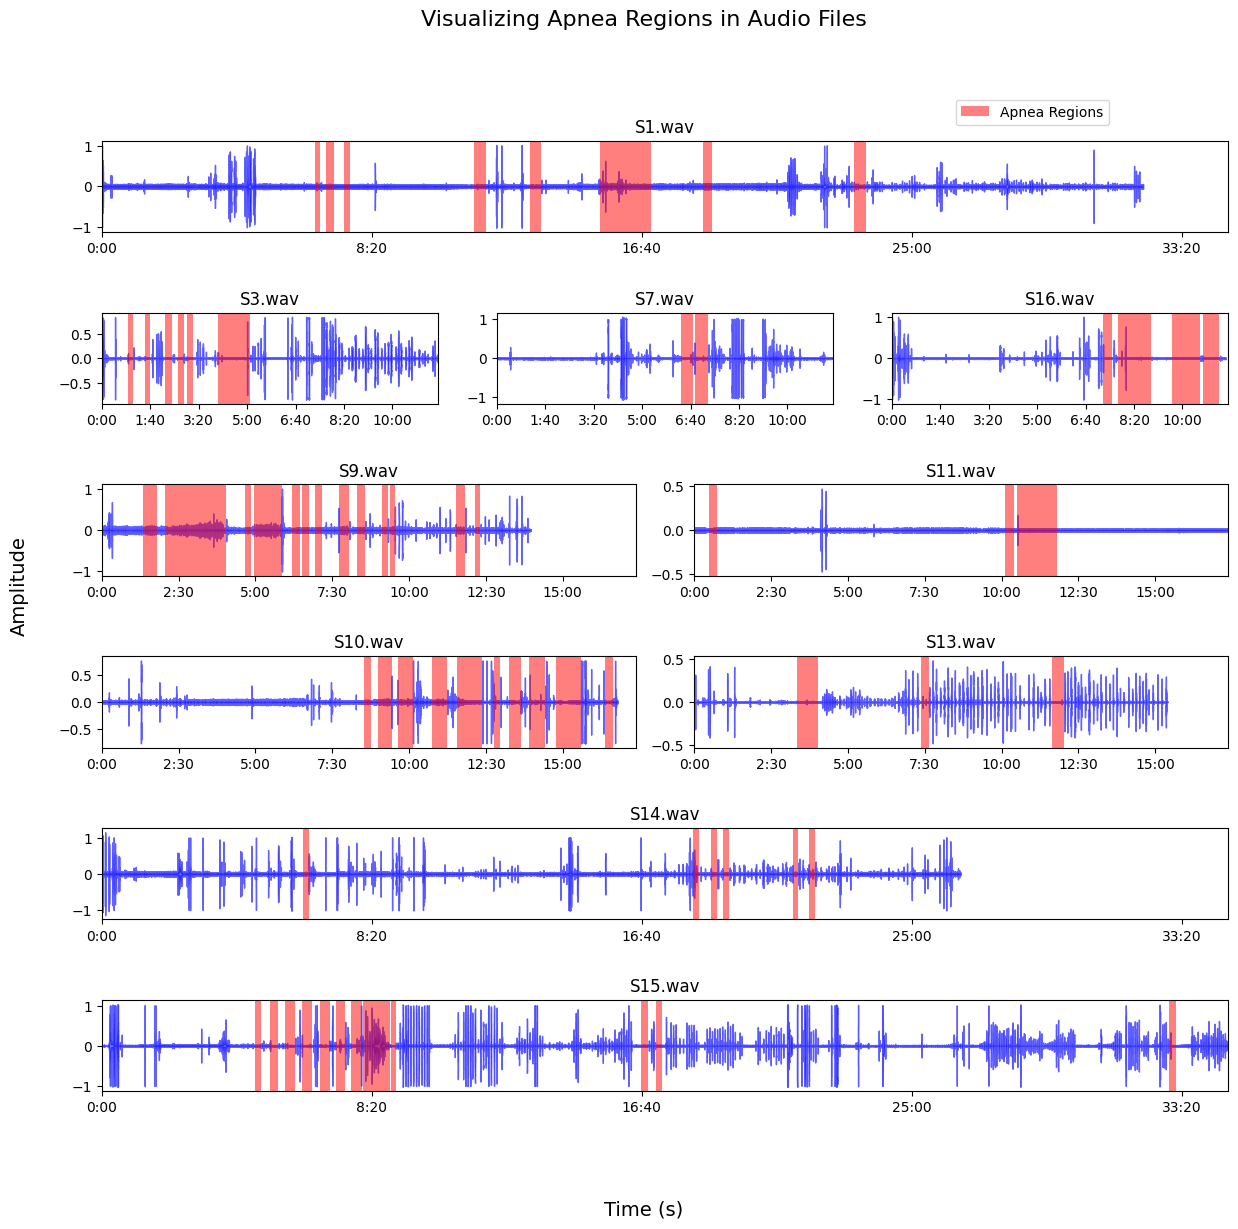

In [ ]:
# Visualization setup
import matplotlib.pyplot as plt
import librosa
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

max_duration = max(len(audio) for audio in X_audio) / Config.Sampling_Rate

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(6, 6, figure=fig)
plt.suptitle("Visualizing Apnea Regions in Audio Files", fontsize=16)

# Plot each audio signal and highlight apnea regions
for idx, audio in enumerate(X_audio):
    sr = Config.Sampling_Rate
    start = 0
    end = int(len(audio) / sr)

    # Adjust subplot arrangement based on index
    if idx == 0:
        ax = fig.add_subplot(gs[0, :])
        ax.set_xlim(0, max_duration)
        legend_elements = [Patch(facecolor='red', edgecolor='none', alpha=0.5, label='Apnea Regions')]
        ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.9, 1.1), fontsize=10)
    elif idx == 1:
        ax = fig.add_subplot(gs[1, :2])
        ax.set_xlim(0, int(max_duration / 3))
    elif idx == 2:
        ax = fig.add_subplot(gs[1, 2:4])
        ax.set_xlim(0, int(max_duration / 3))
    elif idx == 3:
        ax = fig.add_subplot(gs[2, :3])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 4:
        ax = fig.add_subplot(gs[3, :3])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 5:
        ax = fig.add_subplot(gs[2, 3:])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 6:
        ax = fig.add_subplot(gs[3, 3:])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 7:
        ax = fig.add_subplot(gs[4, :])
        ax.set_xlim(0, max_duration)
    elif idx == 8:
        ax = fig.add_subplot(gs[5, :])
        ax.set_xlim(0, max_duration)
    elif idx == 9:
        ax = fig.add_subplot(gs[1, 4:])
        ax.set_xlim(0, int(max_duration / 3))

    librosa.display.waveshow(audio, sr=sr, ax=ax, alpha=0.6, color='blue')
    ax.set_title(f"{sorted_keys[idx]}.wav", fontsize=12)
    ax.set_xlabel(' ')

    # Highlight apnea regions in red
    for i in range(start, end):
        if y_per_second[idx][i] == 1:
            ax.axvspan(i, i + 1, alpha=0.5, edgecolor='none', facecolor='red')

# Configure labels and legend
fig.text(0.5, -0.02, 'Time (s)', ha='center', va='center', fontsize=14)
fig.text(-0.02, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('apnea_visualization.png', dpi=300, bbox_inches='tight')

plt.show()

# 2. Feature Calculation (Mel-Spectrogram, Chroma, MFCC)


In [ ]:
# Re-load data for feature extraction
X_audio, y_per_second, sorted_keys = load_data(raw_dir=Config.Raw_Dir, labels_filepath=Config.Labels_Filepath, sampling_rate=Config.Sampling_Rate)

# Prepare data by creating windows
X_windows = [view_as_windows(sample, window_shape=(Config.Context_Window * Config.Sampling_Rate,), step=Config.Sampling_Rate) for sample in X_audio]
y_windows = [view_as_windows(y_subject, window_shape=(Config.Context_Window,), step=1) for y_subject in y_per_second]

X_flattened = [window for sample in X_windows for window in sample]
y_flattened = [window for subject in y_windows for window in subject]

# Split index for subject data
split_point = [0]
ss = 0
for i in range(10):
    split_point.append(ss + len(X_windows[i]))
    ss += len(X_windows[i])

# Feature extraction
def calculate_feature(X_raw, feature_type):
    """
    Extracts specific features (Mel, MFCC, Chroma) from raw audio data.

    Parameters:
    - X_raw (list): Flattened windows of audio data.
    - feature_type (str): Type of feature to extract ('mel', 'mfcc', 'chroma').

    Returns:
    - list: Extracted features for each sample.
    """
    features = []
    for sample in tqdm(X_raw, desc=f"Calculating {feature_type} Features", unit="sample"):
        if feature_type == "mel":
            feature = librosa.power_to_db(librosa.feature.melspectrogram(y=sample, sr=Config.Sampling_Rate, n_mels=128), ref=np.max)
        elif feature_type == "mfcc":
            feature = librosa.feature.mfcc(y=sample, sr=Config.Sampling_Rate, n_mfcc=32)
        elif feature_type == "chroma":
            feature = librosa.feature.chroma_stft(y=sample, sr=Config.Sampling_Rate, n_chroma=32)
        features.append(feature)
    return features

Data and label have been loaded successfully


In [ ]:
# Extract features for the entire dataset

# X_mel = calculate_feature(X_flattened, feature_type="mel")
# X_mfcc = calculate_feature(X_flattened, feature_type="mfcc")
# X_chroma = calculate_feature(X_flattened, feature_type="chroma")

# y = y_flattened

In [ ]:
# Functions for saving and loading data using pickle
import pickle

def load_from_pickle(filename):
    """
    Loads data from a pickle file.

    Parameters:
    - filename (str): Path to the pickle file.

    Returns:
    - Loaded data object.
    """
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    print(f'Data loaded from {filename}')
    return data

# Load pre-saved feature data
X_mel = load_from_pickle('/content/drive/MyDrive/Apnea_Data/X_mel_features.pkl')
X_mfcc = load_from_pickle('/content/drive/MyDrive/Apnea_Data/X_mfcc_features.pkl')
X_chroma = load_from_pickle('/content/drive/MyDrive/Apnea_Data/X_chroma_features.pkl')
y = load_from_pickle('/content/drive/MyDrive/Apnea_Data/y_labels.pkl')

Data loaded from /content/drive/MyDrive/Apnea_Data/X_mel_features.pkl
Data loaded from /content/drive/MyDrive/Apnea_Data/X_mfcc_features.pkl
Data loaded from /content/drive/MyDrive/Apnea_Data/X_chroma_features.pkl
Data loaded from /content/drive/MyDrive/Apnea_Data/y_labels.pkl


### 2.1 Visualizing features (Mel Spectrogram, MFCC, Chroma)

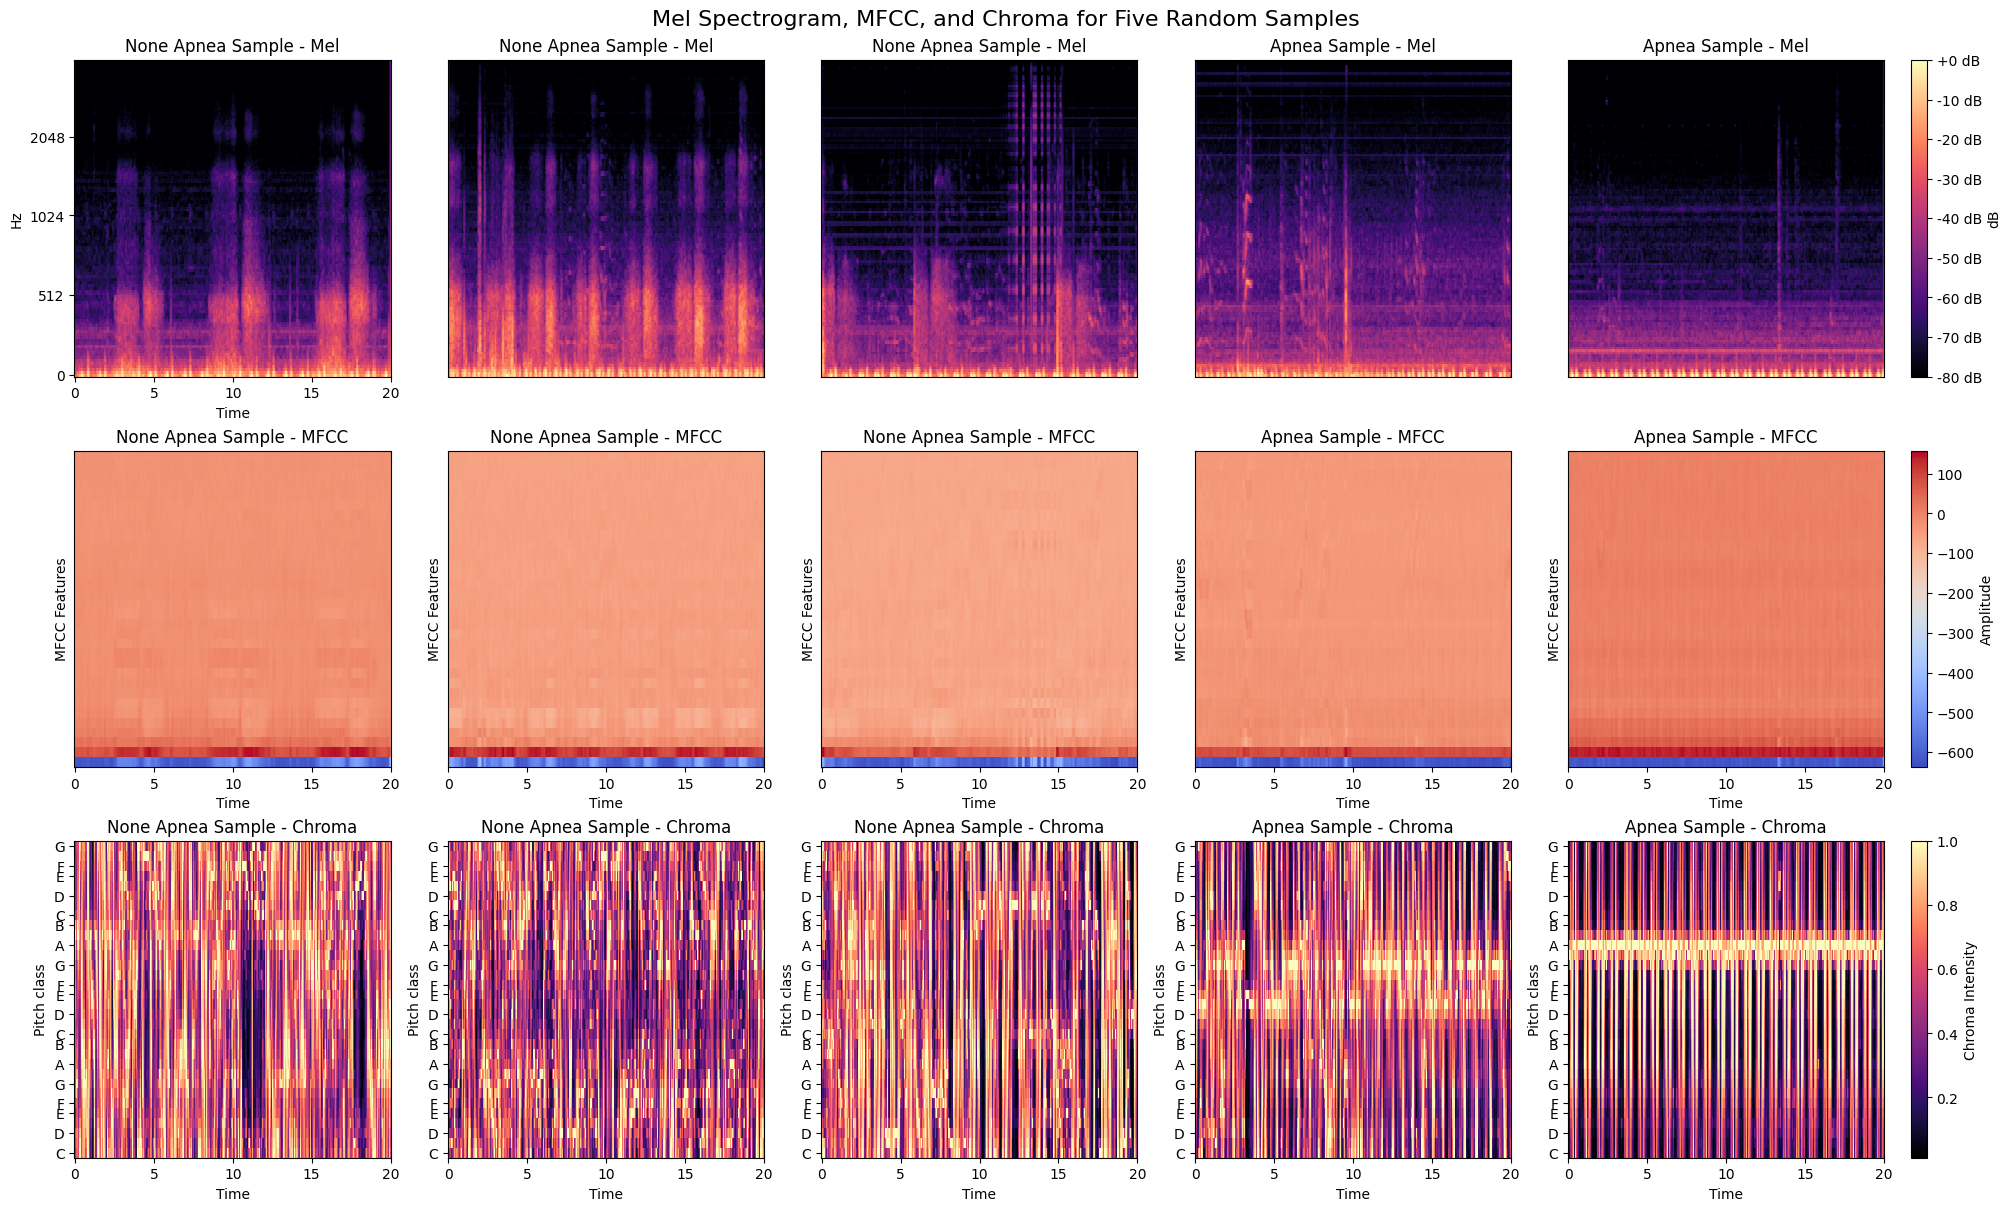

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import librosa.display
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Identify indices for samples with and without apnea
y_all_0 = []  # Indices for non-apnea samples
y_all_1 = []  # Indices for apnea samples
for i, ys in enumerate(y):
    if np.all(y[i] == 0):
        y_all_0.append(i)
    if np.all(y[i] == 1):
        y_all_1.append(i)
random_indices = np.concatenate((random.sample(y_all_0, 3), random.sample(y_all_1, 2)))

fig, axes = plt.subplots(3, 5, figsize=(20, 12), constrained_layout=True)
fig.suptitle("Mel Spectrogram, MFCC, and Chroma for Five Random Samples", fontsize=16)

# Plot Mel spectrograms
mel_im = None
for i, idx in enumerate(random_indices):
    ax = axes[0, i]
    mel_data = X_mel[idx]
    mel_im = librosa.display.specshow(mel_data, sr=Config.Sampling_Rate, x_axis='time', y_axis='mel', ax=ax) if i == 0 else librosa.display.specshow(mel_data, sr=Config.Sampling_Rate, ax=ax)
    ax.set_title(f"{'None Apnea' if i < 3 else 'Apnea'} Sample - Mel")

# Shared colorbar for Mel Spectrogram
cbar = fig.colorbar(mel_im, ax=axes[0, :], location='right', format="%+2.0f dB", pad=0.01)
cbar.set_label('dB')

# Plot MFCCs
mfcc_im = None
for i, idx in enumerate(random_indices):
    ax = axes[1, i]
    mfcc_data = X_mfcc[idx]
    mfcc_im = librosa.display.specshow(mfcc_data, sr=Config.Sampling_Rate, x_axis='time', ax=ax)
    ax.set_ylabel('MFCC Features')
    ax.set_title(f"{'None Apnea' if i < 3 else 'Apnea'} Sample - MFCC")

# Shared colorbar for MFCC
cbar = fig.colorbar(mfcc_im, ax=axes[1, :], location='right', pad=0.01)
cbar.set_label('Amplitude')

# Plot Chroma Features
chroma_im = None
for i, idx in enumerate(random_indices):
    ax = axes[2, i]
    chroma_data = X_chroma[idx]
    chroma_im = librosa.display.specshow(chroma_data, sr=Config.Sampling_Rate, x_axis='time', y_axis='chroma', ax=ax)
    ax.set_title(f"{'None Apnea' if i < 3 else 'Apnea'} Sample - Chroma")

# Shared colorbar for Chroma
cbar = fig.colorbar(chroma_im, ax=axes[2, :], location='right', pad=0.01)
cbar.set_label('Chroma Intensity')

plt.savefig('features_visualization_2.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. DataLoader Setup

In [ ]:
# Class to handle audio dataset with preprocessing for DataLoader
class AudioDataset(Dataset):
    def __init__(self, X_chroma, X_mfcc, X_mel, y, context_window, prediction_window):
        self.X_chroma = X_chroma
        self.X_mfcc = X_mfcc
        self.X_mel = X_mel
        self.y = y
        self.context_window = context_window
        self.prediction_window = prediction_window

    def __len__(self):
        return len(self.X_chroma)

    def __getitem__(self, idx):
        chroma = self.X_chroma[idx]
        mfcc = self.X_mfcc[idx]
        mel = self.X_mel[idx]

        # Process labels for prediction window
        if self.y[idx] is not None:
            label = self.y[idx][
                (self.context_window // 2 - self.prediction_window // 2):
                (self.context_window // 2 + self.prediction_window // 2)
            ]
            label_tensor = torch.tensor(label, dtype=torch.float32)
        else:
            label_tensor = torch.empty(0)  # Placeholder for test data

        # Convert features to tensors
        chroma_tensor = torch.tensor(chroma, dtype=torch.float32)
        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
        mel_tensor = torch.tensor(mel, dtype=torch.float32)

        return chroma_tensor, mfcc_tensor, mel_tensor, label_tensor

def create_data_loader(X_chroma, X_mfcc, X_mel, y, context_window, prediction_window, batch_size=16, shuffle=True):
    """
    Creates DataLoader for the audio dataset.

    Parameters:
    - X_chroma, X_mfcc, X_mel: Feature arrays.
    - y: Label data.
    - context_window: Window size for context in seconds.
    - prediction_window: Window size for prediction in seconds.
    - batch_size (int): Number of samples per batch.
    - shuffle (bool): Whether to shuffle data each epoch.

    Returns:
    - DataLoader object ready for training/testing use.
    """
    dataset = AudioDataset(X_chroma, X_mfcc, X_mel, y, context_window, prediction_window)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# 4. Model Training

In [ ]:
# Define the custom ResNet-like model for time-frequency analysis
class AnisotropicResNet(nn.Module):
    def __init__(self, chroma_in, mfcc_in, prediction_window):
        """
        Initializes the AnisotropicResNet model with specific layers.

        Parameters:
        - chroma_in (int): Input features for chroma.
        - mfcc_in (int): Input features for mfcc.
        - prediction_window (int): Output size of the model.
        """
        super(AnisotropicResNet, self).__init__()

        # Linear transformations to reshape input features
        self.reshape_chroma = nn.Linear(in_features=chroma_in, out_features=128)
        self.reshape_mfcc = nn.Linear(in_features=mfcc_in, out_features=128)

        # Convolution layers for time and frequency dimensions
        self.conv_time = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(1, 7), dilation=1, padding='same')
        self.conv_freq = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=(7, 1), dilation=1, padding='same')

        # Use ResNet18 architecture and modify the final fc layer
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, prediction_window)

    def forward(self, x_chroma, x_mfcc, x_mel):
        """
        Defines the forward pass of the model.

        Parameters:
        - x_chroma, x_mfcc, x_mel: Input feature tensors

        Returns:
        - Output of the model after sequential layers
        """
        x_chroma_reshaped = self.reshape_chroma(x_chroma.permute(0, 2, 1)).permute(0, 2, 1)
        x_mfcc_reshaped = self.reshape_mfcc(x_mfcc.permute(0, 2, 1)).permute(0, 2, 1)
        x = torch.stack((x_chroma_reshaped, x_mfcc_reshaped, x_mel), dim=1)
        x = self.conv_time(x)
        x = self.conv_freq(x)

        return self.resnet(x)

# Function for training the model
def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=0.0001, device='cuda', patience=5, step_size=5, gamma=0.1):
    """
    Trains the given model using the provided data loaders.

    Parameters:
    - model: Model to be trained.
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    - num_epochs, learning_rate: Training hyperparameters.
    - device: Computation device ('cuda' or 'cpu').
    - patience, step_size, gamma: Parameters for learning rate scheduler.

    Returns:
    - Dictionary containing trained model and statistics.
    """
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    f1_metric = MultilabelF1Score(num_labels=Config.Prediction_Window, average='weighted').to(device)

    train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []
    best_val_loss, best_model_state = float('inf'), None
    epochs_without_improvement = 0

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        f1_metric.reset()
        model.train()
        train_loss = 0.0

        for chroma, mfcc, mel, labels in train_loader:
            chroma, mfcc, mel, labels = chroma.to(device), mfcc.to(device), mel.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(chroma, mfcc, mel)
            f1_metric.update(outputs, labels)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        scheduler.step()
        train_loss /= len(train_loader)
        train_f1_score = f1_metric.compute().item()

        train_losses.append(train_loss)
        train_f1_scores.append(train_f1_score)

        f1_metric.reset()
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for chroma, mfcc, mel, labels in val_loader:
                chroma, mfcc, mel, labels = chroma.to(device), mfcc.to(device), mel.to(device), labels.to(device)
                outputs = model(chroma, mfcc, mel)
                f1_metric.update(outputs, labels)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_f1_score = f1_metric.compute().item()

        val_losses.append(val_loss)
        val_f1_scores.append(val_f1_score)

        print(f'Epoch [{epoch + 1}/{num_epochs}]: '
              f'Train Loss: {train_loss:.4f}, Train F1 Score: {train_f1_score:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1_score:.4f}, '
              f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                break

    model.load_state_dict(best_model_state)
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1_scores': train_f1_scores,
        'val_f1_scores': val_f1_scores
    }

# Majority Voting for Predictions
def majority_vote(pred_vectors):
    """
    Applies majority voting across predictions.

    Parameters:
    - pred_vectors (list): List of prediction vectors.

    Returns:
    - list: Majority voted predictions.
    """
    num_vectors = len(pred_vectors)
    vector_length = len(pred_vectors[0])
    final_predictions = []

    for second in range(vector_length + num_vectors - 1):
        votes = [pred_vectors[i][second - i] for i in range(num_vectors) if i <= second < (i + vector_length)]
        final_predictions.append(int(sum(votes) > len(votes) / 2))

    return final_predictions

# Helper Functions (Interval and Metrics Calculation)
def find_apnea_intervals(apnea_vector):
    """
    Finds continuous apnea intervals in a vector.

    Parameters:
    - apnea_vector: Prediction vector containing apnea events.

    Returns:
    - list of tuples: Start and end indices of apnea intervals.
    """
    intervals = []
    start = None

    for i, value in enumerate(apnea_vector):
        if value == 1 and start is None:
            start = i
        elif value == 0 and start is not None:
            if i - start >= 10:
                intervals.append((start, i - 1))
            start = None

    if start is not None and len(apnea_vector) - start >= 10:
        intervals.append((start, len(apnea_vector) - 1))

    return intervals

def calculate_iou(interval1, interval2):
    """
    Calculates the Intersection over Union (IoU) between two intervals.

    Parameters:
    - interval1, interval2: Tuples representing two intervals.

    Returns:
    - float: IoU value.
    """
    start1, end1 = interval1
    start2, end2 = interval2

    inter_start = max(start1, start2)
    inter_end = min(end1, end2)
    if inter_end < inter_start:
        return 0.0
    intersection = inter_end - inter_start + 1

    union = (end1 - start1 + 1) + (end2 - start2 + 1) - intersection
    return intersection / union

def calculate_tp_fp_fn(real_intervals, predicted_intervals, iou_threshold=0.70):
    """
    Computes true positive (TP), false positive (FP), and false negative (FN) counts.

    Parameters:
    - real_intervals: True intervals of apnea.
    - predicted_intervals: Predicted intervals of apnea.
    - iou_threshold (float): IoU threshold for considering a match.

    Returns:
    - Tuple: (TP count, FP count, FN count)
    """
    tp, fp, fn = 0, 0, 0
    matched_real_intervals = set()

    for predicted in predicted_intervals:
        best_iou, best_real = 0, None
        for idx, real in enumerate(real_intervals):
            current_iou = calculate_iou(real, predicted)
            if current_iou > best_iou:
                best_iou = current_iou
                best_real = idx

        if best_iou >= iou_threshold:
            if best_real not in matched_real_intervals:
                tp += 1
                matched_real_intervals.add(best_real)
            else:
                fp += 1
        else:
            fp += 1

    fn = len(real_intervals) - len(matched_real_intervals)
    return tp, fp, fn

def calculate_precision_recall_f1(real_intervals, predicted_intervals, iou_threshold=0.70):
    """
    Calculates precision, recall, and F1 score.

    Parameters:
    - real_intervals: True intervals of apnea.
    - predicted_intervals: Predicted intervals of apnea.
    - iou_threshold (float): IoU threshold for considering a match.

    Returns:
    - Tuple: (Precision, Recall, F1 Score)
    """
    tp, fp, fn = calculate_tp_fp_fn(real_intervals, predicted_intervals, iou_threshold)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1

def calculate_average_time_error(real_intervals, predicted_intervals, iou_threshold=0.70):
    """
    Computes the average time error between real and predicted intervals.

    Parameters:
    - real_intervals: True intervals of apnea.
    - predicted_intervals: Predicted intervals of apnea.
    - iou_threshold (float): IoU threshold for considering a match.

    Returns:
    - float: Average time error.
    """
    total_time_error = 0
    tp = 0

    for predicted in predicted_intervals:
        best_iou = 0
        best_real = None
        for real in real_intervals:
            current_iou = calculate_iou(real, predicted)
            if current_iou > best_iou:
                best_iou = current_iou
                best_real = real

        if best_iou >= iou_threshold:
            if best_real is not None:
                detected_duration = predicted[1] - predicted[0] + 1
                actual_duration = best_real[1] - best_real[0] + 1
                total_time_error += abs(detected_duration - actual_duration)
                tp += 1

    return (total_time_error / tp) if tp > 0 else 0

# Function to reverse the view_as_windows process
def inverse_view_as_windows(windows, step_size):
    """
    Reconstructs original data from windows.

    Parameters:
    - windows (list): List of windows to inverse.
    - step_size (int): Step size used in window creation.

    Returns:
    - list: Reconstructed data.
    """
    out = []
    for window in windows:
        out.extend(window[:step_size])
    return out

# Cross-validation Preparation
def create_custom_folds(X, split_points):
    """
    Creates custom folds for cross-validation based on given split points.

    Parameters:
    - X (list): Dataset to be split.
    - split_points (list): List of indices marking split points.

    Returns:
    - list: List of train-test splits.
    """
    folds = []
    for i in range(len(split_points) - 1):
        test_start, test_end = split_points[i], split_points[i + 1]
        test_indices = list(range(test_start, test_end))
        train_indices = list(set(range(len(X))) - set(test_indices))
        folds.append({'train': train_indices, 'test': test_indices})
    return folds

In [ ]:
# Cross-validation Execution
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom_folds = create_custom_folds(X_flattened, split_point)
# best_models = []

# for fold_idx, fold in enumerate(custom_folds):
#     print(f"Fold {fold_idx + 1}:")
#    X_train_chroma = [X_chroma[i] for i in fold['train']]
#    X_train_mfcc = [X_mfcc[i] for i in fold['train']]
#    X_train_mel = [X_mel[i] for i in fold['train']]
#    y_train = [y[i] for i in fold['train']]
#    X_val_chroma = [X_chroma[i] for i in fold['test']]
#    X_val_mfcc = [X_mfcc[i] for i in fold['test']]
#    X_val_mel = [X_mel[i] for i in fold['test']]
#    y_val = [y[i] for i in fold['test']]

#    train_loader = create_data_loader(X_train_chroma, X_train_mfcc, X_train_mel, y_train, Config.Context_Window, Config.Prediction_Window)
#    val_loader = create_data_loader(X_val_chroma, X_val_mfcc, X_val_mel, y_val, Config.Context_Window, Config.Prediction_Window, shuffle=False)

    # Initialize and train the model
#    model = AnisotropicResNet(chroma_in=32, mfcc_in=32, prediction_window=Config.Prediction_Window)

#    best_model = train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.0001, device=device)
#    best_models.append(best_model)

In [ ]:
# Load saved models
load_directory = "/content/drive/MyDrive/Apnea_Models/"
best_models_loaded = []

for idx in range(10):  # Number of folds
    model = AnisotropicResNet(chroma_in=32, mfcc_in=32, prediction_window=Config.Prediction_Window)
    model_filename = f"best_model_fold_{idx + 1}.pth"
    model_filepath = os.path.join(load_directory, model_filename)

    # Load model state and set to evaluation mode
    model.load_state_dict(torch.load(model_filepath))
    model.eval()
    best_models_loaded.append(model)
    print(f"Model for fold {idx + 1} loaded from {model_filepath}.")

<ipython-input-11-cd8fe0f824fc>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filepath))


Model for fold 1 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_1.pth.
Model for fold 2 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_2.pth.
Model for fold 3 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_3.pth.
Model for fold 4 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_4.pth.
Model for fold 5 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_5.pth.
Model for fold 6 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_6.pth.
Model for fold 7 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_7.pth.
Model for fold 8 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_8.pth.
Model for fold 9 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_9.pth.
Model for fold 10 loaded from /content/drive/MyDrive/Apnea_Models/best_model_fold_10.pth.


In [ ]:
# Collect results for each fold
all_result = {'precision': [], 'recall': [], 'f1': [], 'error': [], 'predicted_interval': [], 'actual_interval': []}
custom_folds = create_custom_folds(X_flattened, split_point)

for fold_idx, fold in enumerate(custom_folds):
    X_val_chroma = [X_chroma[i] for i in fold['test']]
    X_val_mfcc = [X_mfcc[i] for i in fold['test']]
    X_val_mel = [X_mel[i] for i in fold['test']]
    y_val = [y[i] for i in fold['test']]

    val_loader = create_data_loader(X_val_chroma, X_val_mfcc, X_val_mel, y_val, Config.Context_Window, Config.Prediction_Window, shuffle=False)

    best_model = best_models_loaded[fold_idx]

    actual_windows, pred_windows = [], []
    with torch.no_grad():
        for chroma, mfcc, mel, labels in val_loader:
            chroma, mfcc, mel, labels = chroma.to(device), mfcc.to(device), mel.to(device), labels.to(device)
            best_model = best_model.to(device)
            outputs = best_model(chroma, mfcc, mel)
            outputs = torch.sigmoid(outputs)
            binary_outputs = (outputs > 0.5).int()
            actual_windows.extend(labels.cpu().numpy())
            pred_windows.extend(binary_outputs.cpu().numpy())

    actual_per_sec = inverse_view_as_windows(actual_windows, 1)
    pred_per_sec = majority_vote(pred_windows)

    pred_intervals = find_apnea_intervals(pred_per_sec)
    actual_intervals = find_apnea_intervals(actual_per_sec)

    precision, recall, f1 = calculate_precision_recall_f1(actual_intervals, pred_intervals)
    error = calculate_average_time_error(actual_intervals, pred_intervals)

    all_result['precision'].append(precision)
    all_result['recall'].append(recall)
    all_result['f1'].append(f1)
    all_result['error'].append(error)
    all_result['predicted_interval'].append(pred_intervals)
    all_result['actual_interval'].append(actual_intervals)

# tabulate model performance metrics
model_names = [f'Model {i + 1}' for i in range(10)]
df = pd.DataFrame(
    np.array([model_names, all_result['precision'], all_result['recall'], all_result['f1'], all_result['error']]).T,
    columns=['Models', 'precision', 'recall', 'f1', 'error']
)

# Sort results by F1 score
df_sorted = df.sort_values(by='f1', ascending=False)

df_sorted.head(10)

,Models,precision,recall,f1,error
9,Model 10,1.0,0.8,0.888888888888889,7.75
4,Model 5,0.7777777777777778,0.7,0.7368421052631577,3.142857142857143
8,Model 9,1.0,0.25,0.4,2.6666666666666665
6,Model 7,0.3333333333333333,0.3333333333333333,0.3333333333333333,8.0
0,Model 1,0.3,0.375,0.33333333333333326,2.6666666666666665
3,Model 4,0.26666666666666666,0.2857142857142857,0.2758620689655172,4.0
1,Model 2,0.16666666666666666,0.16666666666666666,0.16666666666666666,1.0
2,Model 3,0.0,0.0,0,0
5,Model 6,0.0,0.0,0,0
7,Model 8,0,0.0,0,0


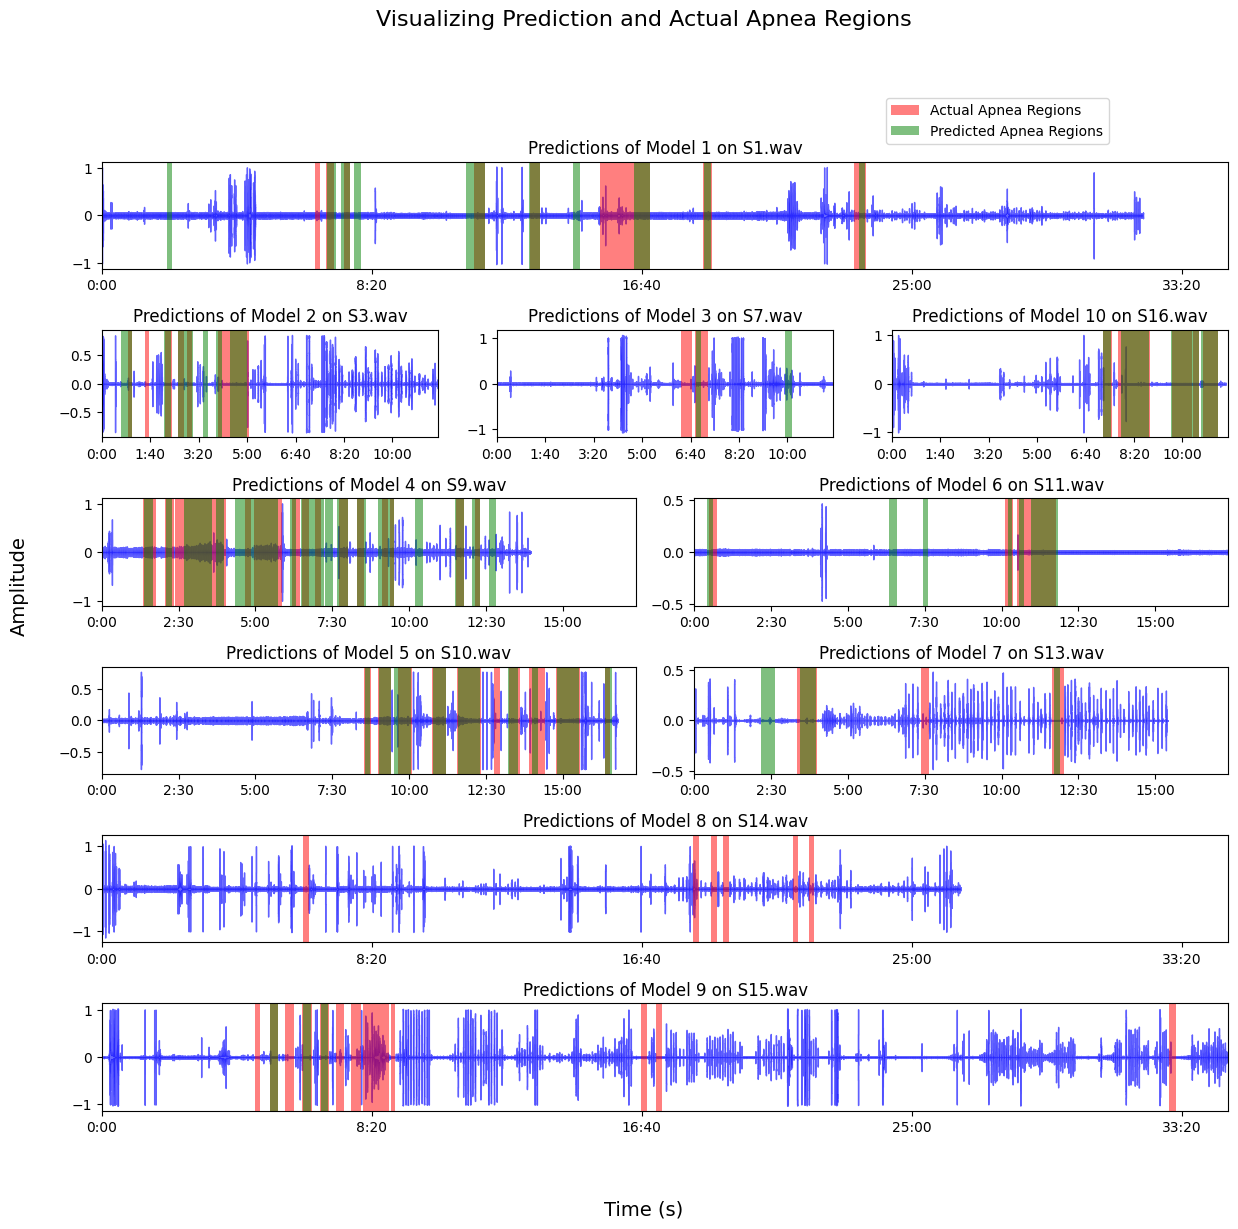

In [ ]:
# Visualization of predictions vs actual apnea regions
import matplotlib.pyplot as plt
import librosa
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

# Calculate maximum duration for setting x-axis limits
max_duration = max(len(audio) for audio in X_audio) / Config.Sampling_Rate

# Initialize the figure
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(6, 6, figure=fig)

plt.suptitle("Visualizing Prediction and Actual Apnea Regions", fontsize=16)

# Loop through each audio file to plot predictions
for idx, audio in enumerate(X_audio):
    sr = Config.Sampling_Rate
    start = 0
    end = int(len(audio) / sr)

    # Plot configuration based on index for layout adjustments
    if idx == 0:
        ax = fig.add_subplot(gs[0, :])
        ax.set_xlim(0, max_duration)
        legend_elements = [
            Patch(facecolor='red', edgecolor='none', alpha=0.5, label='Actual Apnea Regions'),
            Patch(facecolor='green', edgecolor='none', alpha=0.5, label='Predicted Apnea Regions')
        ]
        ax.legend(handles=legend_elements, loc='lower right', bbox_to_anchor=(0.9, 1.1), fontsize=10)
    elif idx == 1:
        ax = fig.add_subplot(gs[1, :2])
        ax.set_xlim(0, int(max_duration / 3))
    elif idx == 2:
        ax = fig.add_subplot(gs[1, 2:4])
        ax.set_xlim(0, int(max_duration / 3))
    elif idx == 3:
        ax = fig.add_subplot(gs[2, :3])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 4:
        ax = fig.add_subplot(gs[3, :3])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 5:
        ax = fig.add_subplot(gs[2, 3:])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 6:
        ax = fig.add_subplot(gs[3, 3:])
        ax.set_xlim(0, int(max_duration / 2))
    elif idx == 7:
        ax = fig.add_subplot(gs[4, :])
        ax.set_xlim(0, max_duration)
    elif idx == 8:
        ax = fig.add_subplot(gs[5, :])
        ax.set_xlim(0, max_duration)
    elif idx == 9:
        ax = fig.add_subplot(gs[1, 4:])
        ax.set_xlim(0, int(max_duration / 3))

    # Plot the audio waveform
    librosa.display.waveshow(audio, sr=sr, ax=ax, alpha=0.6, color='blue')
    ax.set_title(f"Predictions of Model {idx + 1} on {sorted_keys[idx]}.wav", fontsize=12)
    ax.set_xlabel('')

    # Highlight actual apnea regions in red
    for start, end in all_result['actual_interval'][idx]:
        ax.axvspan(start + 5, end + 5, alpha=0.5, edgecolor='none', facecolor='red')

    # Highlight predicted apnea regions in green
    for start, end in all_result['predicted_interval'][idx]:
        ax.axvspan(start + 5, end + 5, alpha=0.5, edgecolor='none', facecolor='green')

# Set labels for figure
fig.text(0.5, -0.02, 'Time (s)', ha='center', va='center', fontsize=14)
fig.text(-0.02, 0.5, 'Amplitude', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('pred_apnea_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Evaluation on Unseen Test data

### 5.1 Loading and Processing Test Data

Test files found: ['Test_S2.wav', 'Test_S6.wav', 'Test_S12.wav']
Loaded Test_S2.wav, audio shape: (11848894,), sample rate: 8000
Processing Subject S2
Number of windows: 1462


Calculating chroma Features: 100%|██████████| 1462/1462 [01:01<00:00, 23.74sample/s]


Test data loader created with 1462 batches
Model 1 predictions collected for Subject S2.
Model 2 predictions collected for Subject S2.
Model 3 predictions collected for Subject S2.
Model 4 predictions collected for Subject S2.
Model 5 predictions collected for Subject S2.
Model 6 predictions collected for Subject S2.
Model 7 predictions collected for Subject S2.
Model 8 predictions collected for Subject S2.
Model 9 predictions collected for Subject S2.
Model 10 predictions collected for Subject S2.
Loaded Test_S6.wav, audio shape: (11182705,), sample rate: 8000
Processing Subject S6
Number of windows: 1378


Calculating chroma Features: 100%|██████████| 1378/1378 [00:58<00:00, 23.39sample/s]


Test data loader created with 1378 batches
Model 1 predictions collected for Subject S6.
Model 2 predictions collected for Subject S6.
Model 3 predictions collected for Subject S6.
Model 4 predictions collected for Subject S6.
Model 5 predictions collected for Subject S6.
Model 6 predictions collected for Subject S6.
Model 7 predictions collected for Subject S6.
Model 8 predictions collected for Subject S6.
Model 9 predictions collected for Subject S6.
Model 10 predictions collected for Subject S6.
Loaded Test_S12.wav, audio shape: (14946526,), sample rate: 8000
Processing Subject S12
Number of windows: 1849


Calculating chroma Features:   0%|          | 0/1849 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Calculating chroma Features: 100%|██████████| 1849/1849 [01:17<00:00, 23.72sample/s]


Test data loader created with 1849 batches
Model 1 predictions collected for Subject S12.
Model 2 predictions collected for Subject S12.
Model 3 predictions collected for Subject S12.
Model 4 predictions collected for Subject S12.
Model 5 predictions collected for Subject S12.
Model 6 predictions collected for Subject S12.
Model 7 predictions collected for Subject S12.
Model 8 predictions collected for Subject S12.
Model 9 predictions collected for Subject S12.
Model 10 predictions collected for Subject S12.


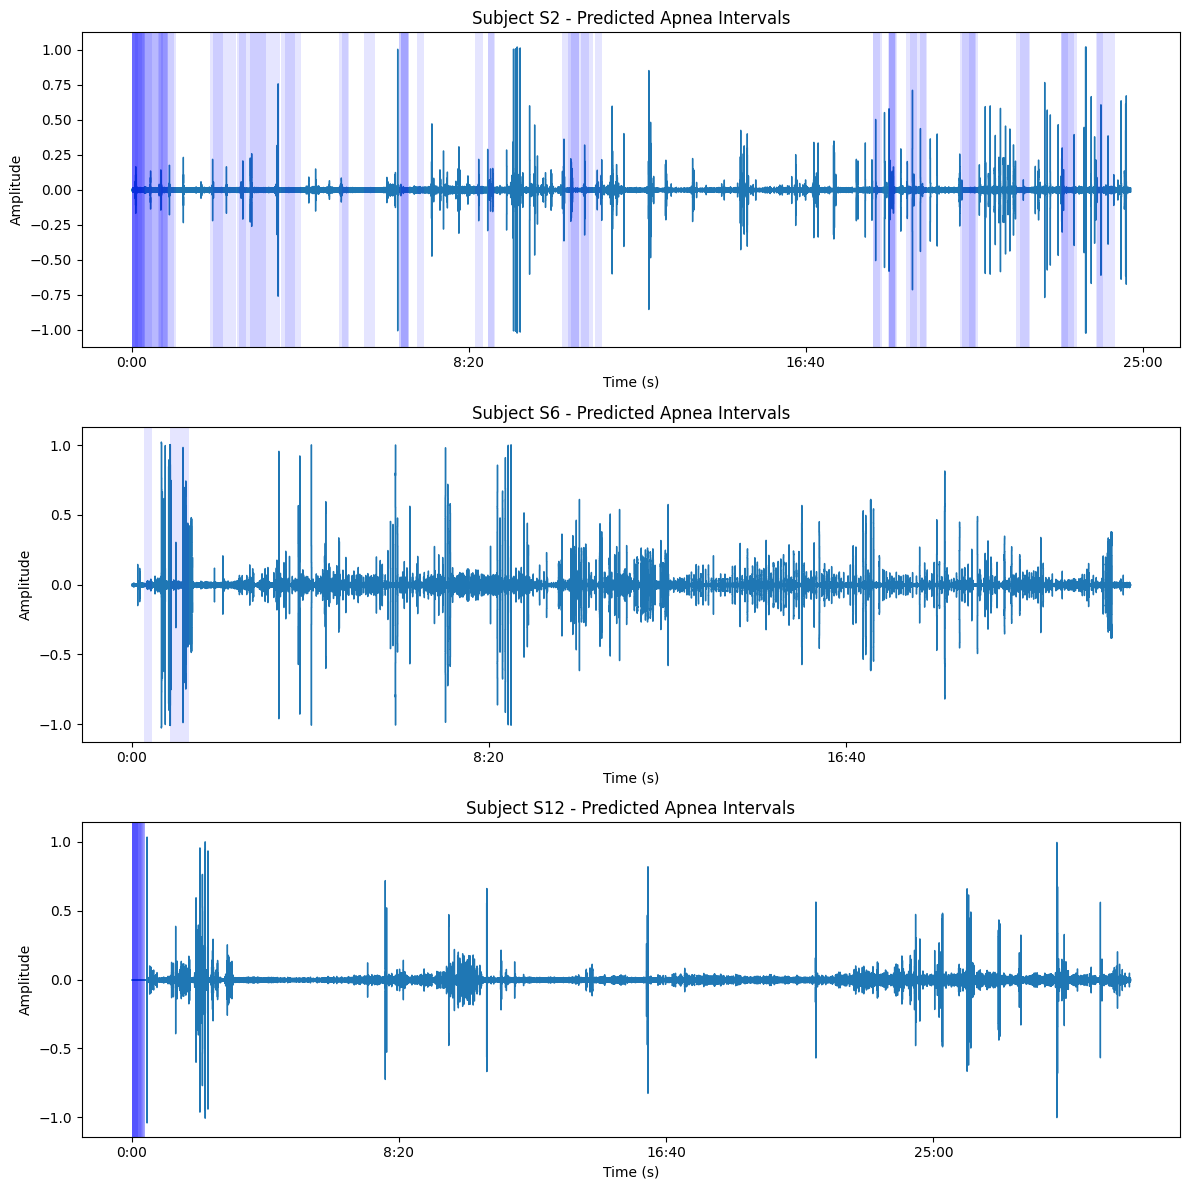

In [ ]:
# Directory containing test audio files
test_files_dir = "/content/drive/MyDrive/CBRC-Apnea/data/test_data"  # Update this to your test data directory

# Verify that the test files are found
test_files = [f for f in os.listdir(test_files_dir) if f.startswith("Test_") and f.endswith(".wav")]
print("Test files found:", test_files)


test_file_predictions = []
if not test_files:
    print("No test files found. Please check the test_files_dir path.")
else:
    plt.figure(figsize=(12, len(test_files) * 4))

    for idx, test_file in enumerate(test_files):
        # Load the test audio file
        audio_path = os.path.join(test_files_dir, test_file)
        audio, sr = librosa.load(audio_path, sr=Config.Sampling_Rate)
        print(f"Loaded {test_file}, audio shape: {audio.shape}, sample rate: {sr}")

        # Extract the subject number
        subject_number = extract_subject_number(test_file)
        print(f"Processing Subject {subject_number}")

        # Create windows of data for the test audio
        window_size = Config.Context_Window * Config.Sampling_Rate
        step_size = Config.Sampling_Rate

        if len(audio) < window_size:
            print(f"Audio {test_file} is shorter than the window size. Skipping.")
            continue

        X_windows = view_as_windows(audio, window_shape=(window_size,), step=step_size)
        print(f"Number of windows: {X_windows.shape[0]}")

        # Calculate features for the test audio
        X_test_mel = calculate_feature(X_windows, feature_type="mel")
        X_test_mfcc = calculate_feature(X_windows, feature_type="mfcc")
        X_test_chroma = calculate_feature(X_windows, feature_type="chroma")

        # Create a dummy y_test (placeholders, as we only need X for predictions)
        y_test = np.zeros((len(X_test_mel), Config.Prediction_Window))

        # Create data loader for test data
        test_loader = create_data_loader(X_test_chroma, X_test_mfcc, X_test_mel, y_test, Config.Context_Window, Config.Prediction_Window, batch_size=1, shuffle=False)
        print(f"Test data loader created with {len(test_loader)} batches")

        # Visualization setup
        plt.subplot(len(test_files), 1, idx + 1)
        plt.title(f'Subject {subject_number} - Predicted Apnea Intervals')
        librosa.display.waveshow(audio, sr=sr, axis='time')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')

        each_model_prediction = {}
        # Test each model individually
        for model_idx, model in enumerate(best_models_loaded):
            # model = model_info['model']  # Extract the model from the dictionary
            model.to(device)
            model.eval()
            pred_windows = []

            with torch.no_grad():
                for chroma, mfcc, mel, _ in test_loader:
                    chroma, mfcc, mel = chroma.to(device), mfcc.to(device), mel.to(device)
                    outputs = model(chroma, mfcc, mel)
                    outputs = torch.sigmoid(outputs)
                    binary_outputs = (outputs > 0.5).int()
                    pred_windows.extend(binary_outputs.cpu().numpy())

            # Generate per-second predictions for this model
            if pred_windows:
                pred_per_sec = majority_vote(pred_windows)
                print(f"Model {model_idx + 1} predictions collected for Subject {subject_number}.")

                # Find predicted apnea intervals
                pred_intervals = find_apnea_intervals(pred_per_sec)
                each_model_prediction[f'Model {model_idx + 1}'] = pred_intervals
                # print(f"Predicted intervals by Model {model_idx + 1}: {pred_intervals}")

                # Format intervals
                formatted_pred_intervals = format_intervals_to_mmss(pred_intervals, Config.Sampling_Rate)

                # Save intervals in specified format
                # save_predictions_to_csv(subject_number, formatted_pred_intervals, f"Test_{subject_number}_predictions_Model{model_idx + 1}")

                # Highlight predicted apnea intervals in the plot
                for s, e in pred_intervals:
                    plt.axvspan(s, e, alpha=0.1, edgecolor='none', facecolor='blue')
            else:
                print(f"No predictions made by Model {model_idx + 1} for {test_file}.")
        test_file_predictions.append(each_model_prediction)
    plt.tight_layout()
    plt.show()

### 5.2 Visualization and Interval Merging

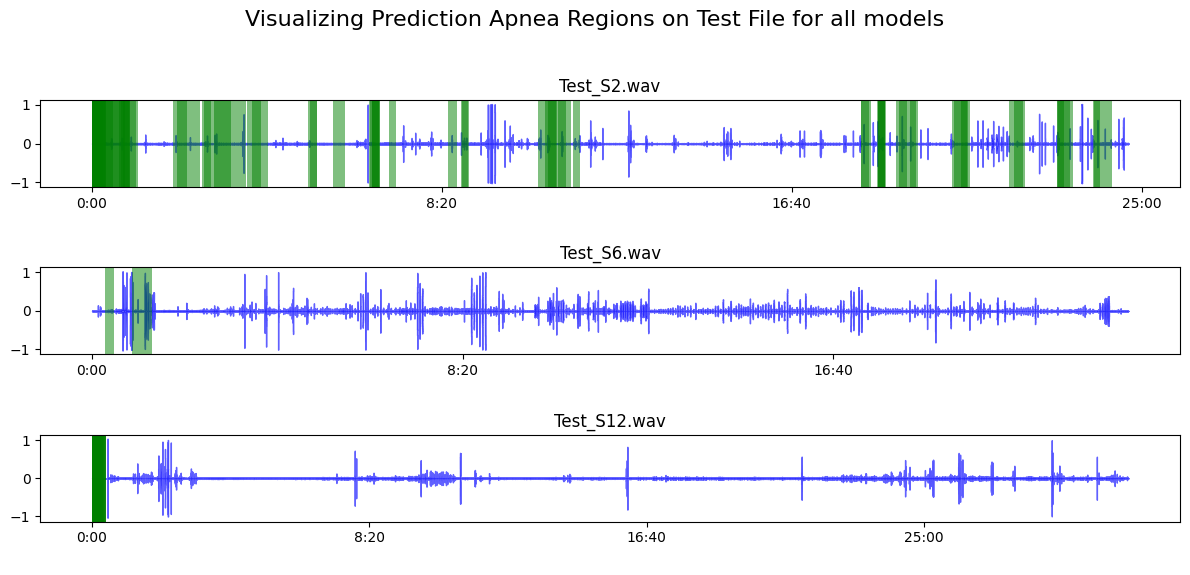

In [ ]:
import matplotlib.pyplot as plt
import librosa
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(3, 1, figure=fig)

plt.suptitle("Visualizing Prediction Apnea Regions on Test File for all models", fontsize=16)

for idx, audio_file in enumerate(test_files):
    audio_path = os.path.join(test_files_dir, audio_file)
    audio, _ = librosa.load(audio_path, sr=Config.Sampling_Rate)

    sr = Config.Sampling_Rate
    start = 0
    end = int(len(audio) / sr)

    ax = fig.add_subplot(gs[idx, 0])

    librosa.display.waveshow(audio, sr=sr, ax=ax, alpha=0.6, color='blue')
    ax.set_title(f"{audio_file}", fontsize=12)
    ax.set_xlabel(' ')

    for intervals_pred_m in test_file_predictions[idx].values():
      for start, end in intervals_pred_m:
        ax.axvspan(start, end, alpha=0.5, edgecolor='none', facecolor='green')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('pred_apnea_visualization_on_test.png', dpi=300, bbox_inches='tight')

plt.show()

S12 Overlapping Intervals (MM:SS):
('00:00', '00:25', ['Model 3', 'Model 7', 'Model 4', 'Model 10', 'Model 8', 'Model 6', 'Model 9', 'Model 2', 'Model 1', 'Model 5'])

S6 Overlapping Intervals (MM:SS):

S2 Overlapping Intervals (MM:SS):
('00:00', '00:54', ['Model 3', 'Model 4', 'Model 8', 'Model 9', 'Model 2', 'Model 1', 'Model 5'])
('06:37', '06:51', ['Model 3', 'Model 1', 'Model 4', 'Model 5'])
('08:49', '08:58', ['Model 5', 'Model 2'])
('10:51', '11:03', ['Model 5', 'Model 2'])
('18:19', '18:30', ['Model 4', 'Model 2'])
('18:43', '18:54', ['Model 4', 'Model 2', 'Model 1', 'Model 5'])
('20:32', '20:52', ['Model 4', 'Model 2'])
('23:00', '23:18', ['Model 4', 'Model 2'])


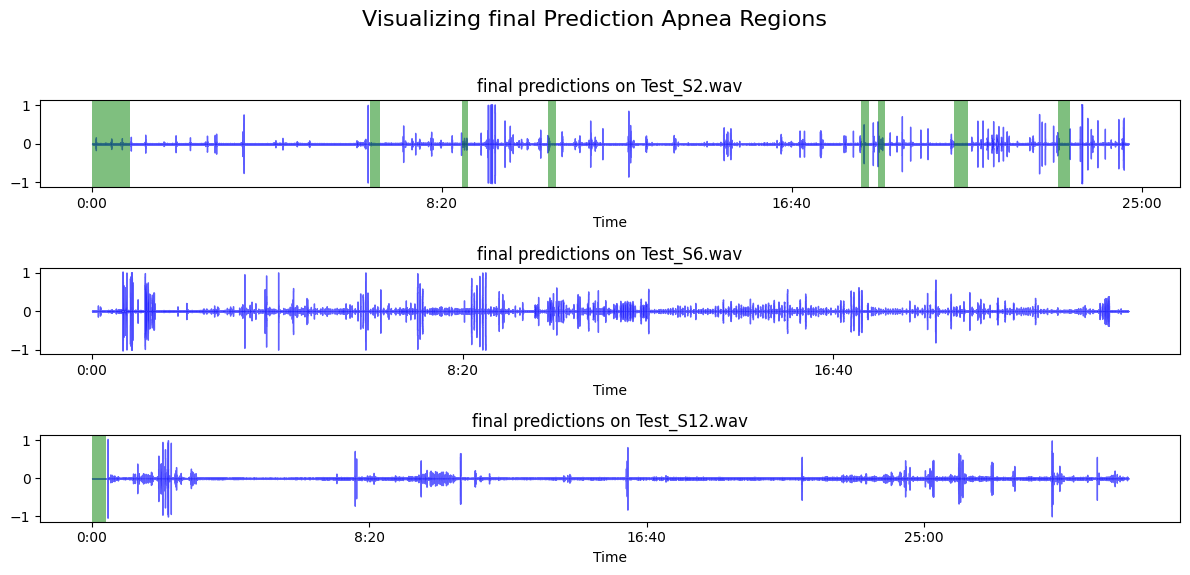

In [ ]:
def seconds_to_mmss(seconds):
    minutes = seconds // 60
    remaining_seconds = seconds % 60
    return f"{int(minutes):02}:{int(remaining_seconds):02}"

def merge_overlapping_intervals(intervals):
    if not intervals:
        return []
    intervals.sort()
    merged = []
    current_start, current_end, current_models = intervals[0]
    for start, end, models in intervals[1:]:
        if start <= current_end:
            current_end = max(current_end, end)
            current_models = list(set(current_models) | set(models))
        else:
            merged.append((current_start, current_end, current_models))
            current_start, current_end, current_models = start, end, models
    merged.append((current_start, current_end, current_models))
    return merged

def find_overlaps_with_threshold(data, min_models=2, min_overlap_ratio=0.7):
    intervals_list = []
    for model, intervals in data.items():
        for start, end in intervals:
            intervals_list.append((start, end, model))
    intervals_list.sort()
    active_intervals = []
    overlapping_intervals = []
    for interval in intervals_list:
        start, end, model = interval
        active_intervals = [a for a in active_intervals if a[1] > start]
        for a_start, a_end, a_model in active_intervals:
            if a_model == model:
                continue
            overlap_start = max(start, a_start)
            overlap_end = min(end, a_end)
            if overlap_start < overlap_end:
                overlap_len = overlap_end - overlap_start
                union_start = min(start, a_start)
                union_end = max(end, a_end)
                union_len = union_end - union_start
                overlap_ratio = overlap_len / union_len
                if overlap_ratio >= min_overlap_ratio:
                    overlapping_intervals.append((overlap_start, overlap_end, [model, a_model]))
        active_intervals.append(interval)
    merged_overlaps = merge_overlapping_intervals(overlapping_intervals)
    result_intervals = [(start, end, models) for start, end, models in merged_overlaps if len(models) >= min_models]
    return result_intervals

def convert_intervals_to_mmss(intervals):
    return [(seconds_to_mmss(start), seconds_to_mmss(end), models) for start, end, models in intervals]

# usage:
S2 = test_file_predictions[0]
S6 = test_file_predictions[1]
S12 = test_file_predictions[2]

result_S12 = find_overlaps_with_threshold(S12)
result_S6 = find_overlaps_with_threshold(S6)
result_S2 = find_overlaps_with_threshold(S2)

result_S12_mmss = convert_intervals_to_mmss(result_S12)
result_S6_mmss = convert_intervals_to_mmss(result_S6)
result_S2_mmss = convert_intervals_to_mmss(result_S2)

print("S12 Overlapping Intervals (MM:SS):")
for interval in result_S12_mmss:
    print(interval)

print("\nS6 Overlapping Intervals (MM:SS):")
for interval in result_S6_mmss:
    print(interval)

print("\nS2 Overlapping Intervals (MM:SS):")
for interval in result_S2_mmss:
    print(interval)

test_results = [result_S2,result_S6,result_S12]
# Visualization code for final results
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(3, 1, figure=fig)

plt.suptitle("Visualizing final Prediction Apnea Regions", fontsize=16)

for idx, audio_file in enumerate(test_files):
    audio_path = os.path.join(test_files_dir, audio_file)
    audio, _ = librosa.load(audio_path, sr=Config.Sampling_Rate)

    ax = fig.add_subplot(gs[idx, 0])
    librosa.display.waveshow(audio, sr=sr, ax=ax, alpha=0.6, color='blue')
    ax.set_title(f"final predictions on {audio_file}", fontsize=12)

    for intervals_pred_m in test_results[idx]:
        start, end = intervals_pred_m[0:2]
        ax.axvspan(start, end, alpha=0.5, edgecolor='none', facecolor='green')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('pred_apnea_visualization_on_test_final.png', dpi=300, bbox_inches='tight')
plt.show()


### 5.3 Saving Results

In [ ]:
ls = []
for S in S12_time:
    ls.append(['12', S[0], S[1]])
for S in S6_time:
    ls.append(['6', S[0], S[1]])
for S in S2_time:
    ls.append(['2', S[0], S[1]])

df = pd.DataFrame(ls, columns=['subject_number', 'RD_start', 'RD_end'])
df.to_csv('/content/CBRC.csv', index=False)